In [1]:
import itertools
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import os

from scipy.spatial import distance

In [2]:
def kmerArray(sequence, k):
    kmer = []
    for i in range(len(sequence) - k + 1):
        if "P" not in sequence[i:i + k]:
            kmer.append(sequence[i:i + k])
    return kmer


def Kmer(sequences, k=3, NA = 'ACGU', normalize=True):

    encodings = []

    header = []
    for kmer in itertools.product(NA, repeat=k):
        header.append(''.join(kmer))

    for sequence in sequences:

        kmers = kmerArray(sequence, k)

        count = Counter()
        count.update(kmers)

        if normalize == True:
            for key in count:
                count[key] = count[key] / len(kmers)

        code = []
        for j in range(0, len(header)):
            if header[j] in count:
                code.append(count[header[j]])
            else:
                code.append(0)
    
        encodings.append(code)

    return encodings

In [ ]:
DATASET_DIR = Path(os.getcwd()).parent / "dataset"

path_train = DATASET_DIR / "folds/fold_1_train.pickle"
path_val  = DATASET_DIR / "folds/fold_1_val.pickle"
path_test  = DATASET_DIR / "test_set.pickle"


with open(path_train, "rb") as f:
    train_data = pickle.load(f)
with open(path_val, "rb") as f:
    val_data = pickle.load(f)
with open(path_test, "rb") as f:
    test_data = pickle.load(f)

positive_keys = ['type_1', 'type_2', 'type_3', 'type_4']
negative_keys = ["negative"]
positive_seqs_train = ["".join([x if x != "T" else "U" for x in seq]) for key in positive_keys for seq in train_data[key]]
negative_seqs_train = ["".join([x if x != "T" else "U" for x in seq]) for key in negative_keys for seq in train_data[key]]
positive_seqs_val = ["".join([x if x != "T" else "U" for x in seq]) for key in positive_keys for seq in val_data[key]]
negative_seqs_val = ["".join([x if x != "T" else "U" for x in seq]) for key in negative_keys for seq in val_data[key]]
positive_seqs_test = ["".join([x if x != "T" else "U" for x in seq]) for key in positive_keys for seq in test_data[key]]
negative_seqs_test = ["".join([x if x != "T" else "U" for x in seq]) for key in negative_keys for seq in test_data[key]]

negatives_current = negative_seqs_train + negative_seqs_val + negative_seqs_test
positives_current = positive_seqs_train + positive_seqs_val + positive_seqs_test


path_train = Path("./data_mlm5c/train_m5C_201_2.txt")
path_test  = Path("./data_mlm5c/test_m5C_201_2.txt")

df_train = pd.read_csv(path_train, sep=",", header=None)
df_test  = pd.read_csv(path_test,  sep=",", header=None)

negatives_mlm5c_train = df_train[df_train[1] == 0][0].to_list()
negatives_mlm5c_test = df_test[df_test[1] == 0][0].to_list()
positives_mlm5c_train = df_train[df_train[1] == 1][0].to_list()
positives_mlm5c_test = df_test[df_test[1] == 1][0].to_list()
negatives_mlm5c = negatives_mlm5c_train + negatives_mlm5c_test
positives_mlm5c = positives_mlm5c_train + positives_mlm5c_test


In [61]:
js_matrices = {}
for kmer in range(1,5):
    tnc_mlm5c_negatives = Kmer(negatives_mlm5c, k=kmer, NA='ACGU', normalize=False)
    tnc_mlm5c_positives = Kmer(positives_mlm5c, k=kmer, NA='ACGU', normalize=False)
    tnc_negatives_current = Kmer(negatives_current, k=kmer, NA='ACGU', normalize=False)
    tnc_positives_current = Kmer(positives_current, k=kmer, NA='ACGU', normalize=False)
    tnc_mlm5c_negatives = np.sum(tnc_mlm5c_negatives, axis = 0) / np.sum(tnc_mlm5c_negatives)
    tnc_mlm5c_positives = np.sum(tnc_mlm5c_positives, axis = 0) / np.sum(tnc_mlm5c_positives)
    tnc_negatives_current = np.sum(tnc_negatives_current, axis = 0) / np.sum(tnc_negatives_current)
    tnc_positives_current = np.sum(tnc_positives_current, axis = 0) / np.sum(tnc_positives_current)
    freq = np.vstack((tnc_mlm5c_negatives, tnc_mlm5c_positives, tnc_negatives_current, tnc_positives_current))
    js_condensed = distance.pdist(freq,
                                metric=lambda u, v: distance.jensenshannon(u, v, base=2))
    js_matrix = distance.squareform(js_condensed)
    df_js = pd.DataFrame(js_matrix, index=["Mlm5C N", "Mlm5C P", "Current N", "Current P"],
                     columns=["Mlm5C N", "Mlm5C P", "Current N", "Current P"])
    js_matrices[kmer] = df_js

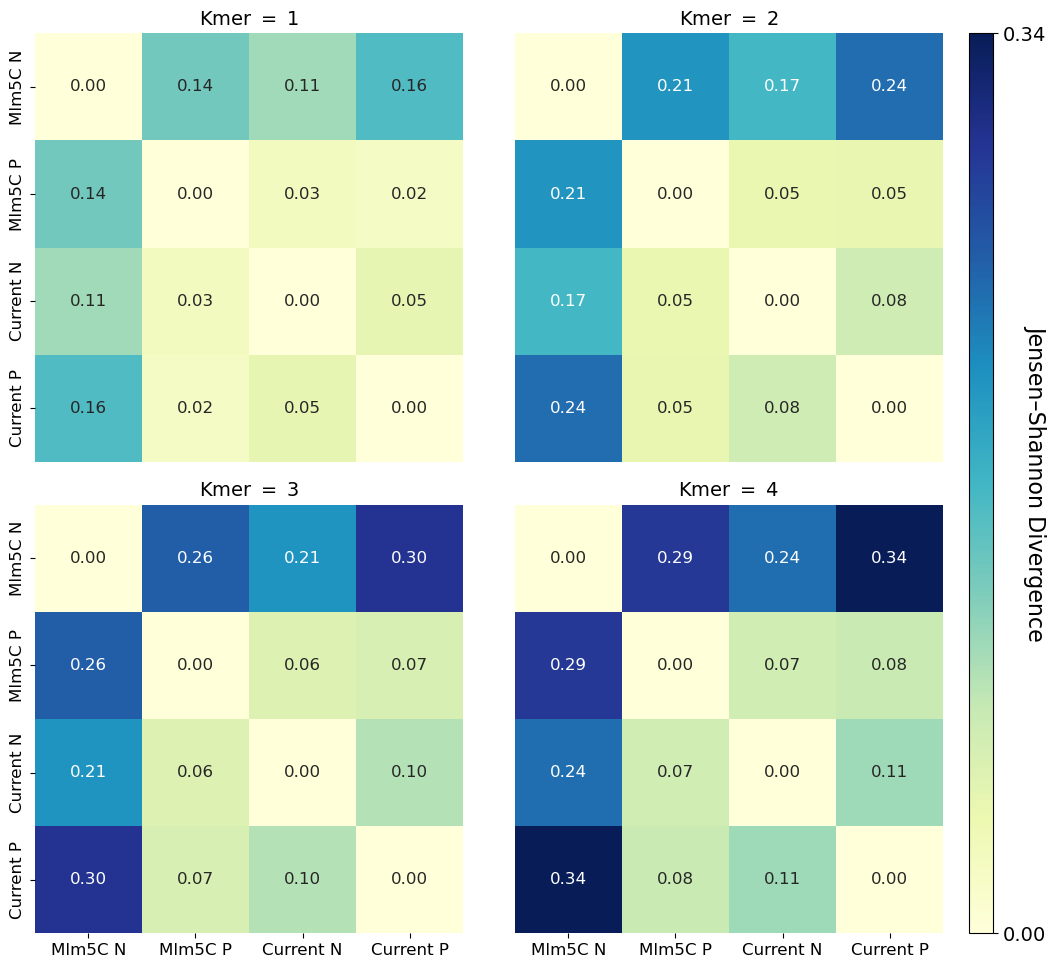

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

# assume js_matrices is already defined

# compute global vmin/vmax
all_vals = np.concatenate([df.values.flatten() for df in js_matrices.values()])
vmin, vmax = all_vals.min(), all_vals.max()

# set up GridSpec: 2 rows × 2 cols for heatmaps, reserve 15% of width on the right for cbar
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(nrows=2, ncols=2,
                       left=0.05, right=0.85,  # heatmaps occupy 0.05–0.85 of width
                       bottom=0.05, top=0.95,
                       wspace=0.00, hspace=0.1)

# create 2×2 axes
axes = []
for i in range(2):
    row_axes = []
    for j in range(2):
        ax = fig.add_subplot(gs[i, j])
        row_axes.append(ax)
    axes.append(row_axes)

# plot each heatmap without its own cbar, capture one mappable
mappable = None
for idx, (kmer, df_js) in enumerate(js_matrices.items()):
    row, col = divmod(idx, 2)
    ax = axes[row][col]
    m = sns.heatmap(df_js,
                    annot=True,
                    cmap="YlGnBu",
                    annot_kws={"size": 12},
                    fmt=".2f",
                    square=True,
                    vmin=vmin,
                    vmax=vmax,
                    cbar=False,      # NO individual cbar
                    ax=ax)
    ax.set_title(f"Kmer $=$ {kmer}", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    # hide ticks per your logic
    if row == 0:
        ax.set_xticks([])
        ax.set_xticklabels([])
        if col == 1:
            ax.set_yticks([])
            ax.set_yticklabels([])
    else:
        if col == 1:
            ax.set_yticks([])
            ax.set_yticklabels([])
    mappable = m  # grab the QuadMesh

# now add one colorbar axis on the right
cbar_ax = fig.add_axes([0.85, 0.05, 0.02, 0.9])  
# [left, bottom, width, height] in figure coords
fig.colorbar(mappable.get_children()[0], 
             cax=cbar_ax,
             orientation='vertical')\
   .set_label('Jensen–Shannon Divergence', fontsize=16, rotation=270, labelpad=1)

#change the ticks of the colorbar to only vmin and vmax
cbar_ax.set_yticks([vmin, vmax])
cbar_ax.set_yticklabels([f"{vmin:.2f}", f"{vmax:.2f}"], fontsize=14)

#save pdf

plt.savefig("./results/atlas_analysis/js_divergence_kmer.pdf", bbox_inches='tight')

